In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.3.2-rc.1 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure


Unconverged tracks (from runs that didn't fail):

In [6]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


# Results
## Summit

In [2]:
summit = analyze.Analysis('results/summit')
print(summit)
summed = summit.summed
problems = summit.problems()
problem_to_abbr = summit.problem_to_abbr(problems)
p_to_i = dict(zip(problems, itertools.count()))

Analysis for Celeritas v0.4.0-dev.91+cf7c5a7bc on summit


### Failures

Average number of unconverged tracks:

In [9]:
unconv = analyze.summarize_instances(summit.result['unconverged'])['mean']
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


### Timing tables

In [10]:
(fig, [run_ax, setup_ax]) = plt.subplots(nrows=2,
                                         gridspec_kw=dict(height_ratios=[3, 1]),
                                         subplot_kw=dict(yscale='log'))
summit.plot_results(run_ax, summed['total_time'])
run_ax.legend();
run_ax.set_ylabel('Run [s]')
run_ax.tick_params(labelbottom=False)
summit.plot_results(setup_ax, summed['setup_time'])
setup_ax.set_ylabel('Setup [s]')
analyze.annotate_metadata(run_ax, summit)
plt.tight_layout()
fig.savefig('plots/timing.pdf', transparent=True)
plt.close()

In [11]:
times = summed[('total_time', 'mean')].unstack()
times.style.format(analyze.float_fmt_transform(2))

In [13]:
testem3 = event_rate['mean'].xs('testem3-flat+field+msc', level='problem').unstack('arch')

In [15]:
#testem3 / testem3.loc[('vecgeom', 'cpu')]

In [16]:
speedup = analyze.get_cpugpu_ratio(summed['total_time'])
speedup.dropna().style.format(analyze.float_fmt_transform(1))

KeyError: 'cpu'

In [17]:
speedup['mean'].unstack('geo').describe()

NameError: name 'speedup' is not defined

In [ ]:
#df = speedup.apply(np.vectorize(analyze.float_fmt_transform(1)))
speedup_out = np.full((len(speedup), 3), "", dtype=object)
_abbrev = summit.problem_to_abbr()
prev_prob = None
for (i, ((prob, geo), row)) in enumerate(speedup.iterrows()):
    if prob != prev_prob:
        abbr = _abbrev[prob]
        speedup_out[i, 0] = f"{prob} [{abbr}]"
    speedup_out[i, 1] = geo
    speedup_out[i, 2] = "{:.1f}× (±{:.1f})".format(*row)
    prev_prob = prob
    
with open("results/summit/speedup.md", "w") as f:
    analyze.dump_markdown(f,
                  ["Problem", "Geometry", "Speedup"], 
                  np.concatenate([speedup_out, [headers]], axis=0),
                  alignnment="<<>")

In [ ]:
_desc = (speedup['mean'].dropna() * 7).describe()
print("CPU:GPU equivalence: {min:.0f}× to {max:.0f}×".format(**_desc))

In [19]:
# Determine the fraction of action time spent in geometry routines
action_times_inst = analyze.unstack_subdict(summit.result['action_times'][summit.valid]).T
total_time_inst = summit.result['total_time']
geo_actions = [lab for lab in action_times_inst.index
               if lab.startswith('along-step-') or lab.startswith('geo-')]
geo_frac_inst = action_times_inst.loc[geo_actions].sum() / total_time_inst
geo_frac = analyze.summarize_instances(geo_frac_inst)

In [20]:
geo_frac['mean'].unstack('arch')[['cpu', 'gpu+sync']]

KeyError: "['cpu'] not in index"

### Plots

NameError: name 'speedup' is not defined

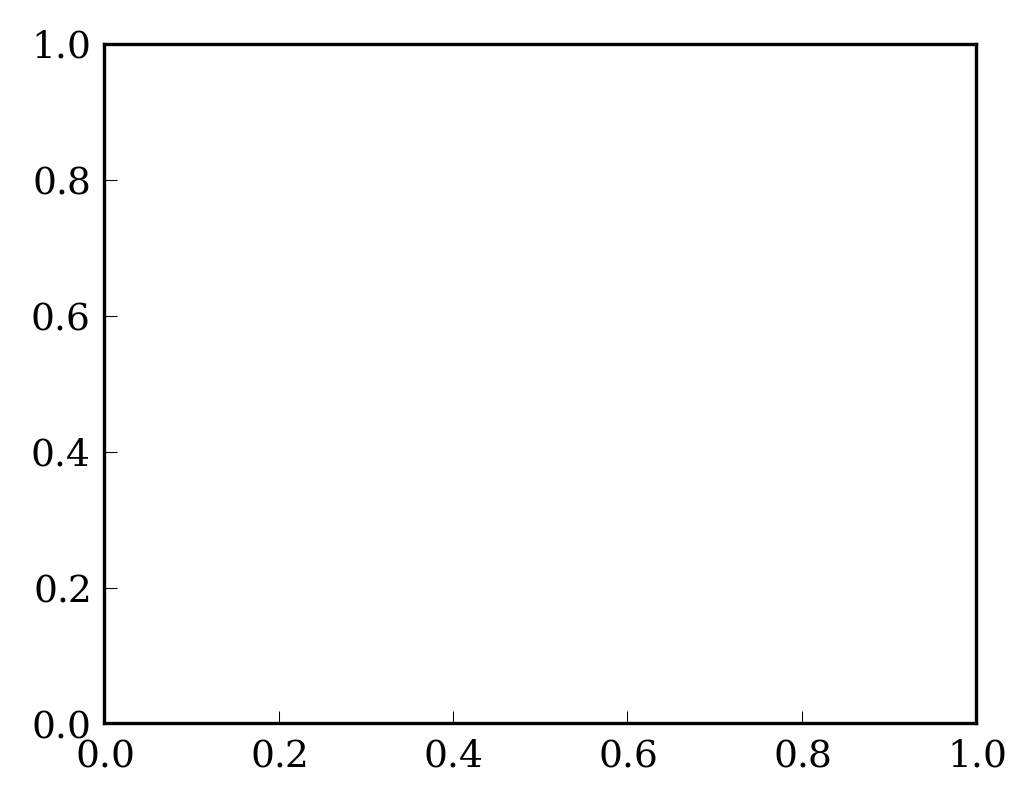

In [21]:
fig, ax = plt.subplots()
summit.plot_results(ax, speedup)
ax.set_ylabel("Speedup (7-CPU / 1-GPU wall time)")
ax.set_ylim([0, None])
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/speedups.pdf', transparent=True)
fig.savefig('results/summit/speedup.png', transparent=False, dpi=150)
plt.close()

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(4,4), subplot_kw=dict(yscale='log'))
for (ax, q) in zip(axes, ['step', 'primary']):
    summit.plot_results(ax, analyze.inverse_summary(summed['avg_time_per_' + q]))
    ax.set_ylabel(q + ' per sec')
    if ax != axes[-1]:
        ax.tick_params(labelbottom=False)
    ax.legend()
plt.tight_layout()
fig.savefig('plots/steps-vs-primaries.pdf')
plt.close()

In [23]:
(fig, (time_ax, geo_ax)) = plt.subplots(
    nrows=2, #figsize=(4, 4),
    gridspec_kw=dict(height_ratios=[3, 1])
)
plot_event_rate(time_ax, summit)
time_ax.tick_params(labelbottom=False)
time_ax.legend()
summit.plot_results(geo_ax, geo_frac * 100)
geo_ax.set_ylabel("Geometry [%]")
geo_ax.set_ylim([0, 100])
plt.tight_layout()
fig.savefig('plots/throughput-geo.pdf', transparent=True)
plt.close()

### Action fraction pie charts

In [ ]:
avg_time = summed[('total_time', 'mean')].T
mean_action_times = summit.action_times().xs('mean', axis=1, level=1).T

In [ ]:
for (prob, geo) in itertools.product(
        ["testem15+field", "testem3-flat+field+msc", "cms2018+field+msc"],
        ["vecgeom", "orange"]):
    try:
        plot_times = mean_action_times.xs((prob, geo), axis=1, level=('problem', 'geo')).dropna(axis=1, how='all')
    except KeyError:
        plot_times = pd.DataFrame()
    if plot_times.empty:
        print("Missing problem/geo:", prob, geo)
        continue
    md = {k: getattr(summit, k) for k in ["version", "system"]}
    pieplot = analyze.PiePlotter(plot_times)
    
    # Loop over CPU/GPU
    for arch in pieplot.times:
        (fig, ax) = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"),
                                 layout="constrained")
        pieplot(ax, arch)
        name = (prob, geo, arch)
        slashname = "/".join(name)
        fig.text(
            0.98, 0.1, f"{slashname}\n{md['version']} on {md['system']}",
            va='bottom', ha='right',
            fontstyle='italic', color=(0.75,)*4, size='xx-small',
#            zorder=-100
        )

        dashname = "-".join(name)        
        fig.savefig(f'plots/actions-{dashname}.pdf', transparent=True)
        plt.close()

### Plot per-step timing on GPU

In [ ]:
for p in ['cms2018', 'cms2018+field+msc']:
    data = summit.load_results((p, 'vecgeom', 'gpu'), 0)
    (fig, axes) = plt.subplots(nrows=2, figsize=(3, 4), sharex=True)
    for i, ax, plot in zip(itertools.count(),
                           axes,
                           [analyze.plot_counts, analyze.plot_accum_time_inv]):
        objs = plot(ax, data)
        analyze.annotate_metadata(ax, data['_metadata'])
        if i == 0:
            ax.set_xlabel(None)
    fig.savefig(f'plots/per-step-{p}.pdf', transparent=True)
    plt.tight_layout()
    plt.close()
    
    (fig, ax) = plt.subplots(figsize=(4, 3))
    analyze.plot_time_per_step(ax, data, scale=2)
    analyze.annotate_metadata(ax, summit)
    plt.tight_layout()
    fig.savefig(f'plots/time-per-step-{p}.pdf', transparent=True)
    plt.close()

## Crusher

In [3]:
def get_step_times(results):
    new_idx = []
    times = []
    for i in results.index:
        try:
            outp = results.load_results(i, 0)
            step_times = analyze.StepTimeGetter(outp, stream=0)()
        except Exception:
            continue
        times.append([step_times[i] for i in range(2)])
        new_idx.append(i)
    return pd.DataFrame(times, index=pd.MultiIndex.from_tuples(new_idx))

In [4]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.4.0-dev.91+cf7c5a7bc on crusher


In [5]:
csum = analyze.summarize_instances(crusher.result[crusher.successful].dropna(how='all'))

In [6]:
csum[('total_time', 'mean')].unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,87.957981,14.738531,NaN
simple-cms+field+msc,orange,127.361742,14.931266,NaN
simple-cms+msc,orange,86.169489,12.544426,NaN
testem15,orange,97.014769,14.091467,NaN
testem15+field,orange,60.731631,14.056410,14.666759
testem15+field+msc,orange,107.118559,14.325120,NaN
testem3-flat,orange,162.510902,15.293731,NaN
testem3-flat+field,orange,212.684507,17.838255,NaN
testem3-flat+field+msc,orange,133.394158,22.726437,22.344604


In [7]:
step_times = get_step_times(crusher)
step_times

,,,0,1
testem15,orange,gpu,10.000665,0.000832
testem15+field,orange,gpu,9.884015,0.000844
testem15+field+msc,orange,gpu,9.752522,0.000996
simple-cms+msc,orange,gpu,8.361841,0.000626
simple-cms+field,orange,gpu,9.758305,0.000910
simple-cms+field+msc,orange,gpu,9.357020,0.000960
testem3-flat,orange,gpu,8.550394,0.000573
testem3-flat+field,orange,gpu,9.026497,0.000630
testem3-flat+msc,orange,gpu,8.621627,0.000606
testem3-flat+field+msc,orange,gpu,10.989945,0.000661


In [8]:
step_times[0] / step_times[1]

testem15                orange  gpu         12013.863869
testem15+field          orange  gpu         11707.589511
testem15+field+msc      orange  gpu          9789.988309
simple-cms+msc          orange  gpu         13346.934217
simple-cms+field        orange  gpu         10724.272719
simple-cms+field+msc    orange  gpu          9750.318736
testem3-flat            orange  gpu         14920.669080
testem3-flat+field      orange  gpu         14322.384512
testem3-flat+msc        orange  gpu         14222.390207
testem3-flat+field+msc  orange  gpu         16638.701382
testem15+field          orange  gpu+sync     9910.207845
testem3-flat+field+msc  orange  gpu+sync    11756.718993
dtype: float64

In [9]:
analyze.get_cpugpu_ratio(csum['total_time'])

,,mean,std
problem,geo,,
simple-cms+field,orange,5.967893,1.747349
simple-cms+field+msc,orange,8.529869,1.332233
simple-cms+msc,orange,6.869146,1.778651
testem15,orange,6.884647,3.400296
testem15+field,orange,4.320565,1.308422
testem15+field+msc,orange,7.477673,2.808468
testem3-flat,orange,10.625981,3.704805
testem3-flat+field,orange,11.922943,4.258723
testem3-flat+field+msc,orange,5.869559,1.260580


In [11]:
crusher_rates = analyze.calc_event_rate(crusher, csum)
summit_rates = analyze.calc_event_rate(summit, summed.loc[crusher_rates.index])

counts = {
    ('summit', 'cpu'): 7,
    ('summit', 'gpu'): 1,
    ('crusher', 'cpu'): 8,
    ('crusher', 'gpu'): 1,
}

KeyError: "[('simple-cms+field', 'orange', 'cpu'), ('simple-cms+field+msc', 'orange', 'cpu'), ('simple-cms+msc', 'orange', 'cpu'), ('testem15', 'orange', 'cpu'), ('testem15+field', 'orange', 'cpu'), ('testem15+field+msc', 'orange', 'cpu'), ('testem3-flat', 'orange', 'cpu'), ('testem3-flat+field', 'orange', 'cpu'), ('testem3-flat+field+msc', 'orange', 'cpu'), ('testem3-flat+msc', 'orange', 'cpu')] not in index"

In [ ]:
(crusher_rates['mean'] / summit_rates['mean']).unstack()

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
for offset, color, machine, rates in [(-0.05, '#7A954F', 'Summit', summit_rates),
                                      (0.05, '#BC5544', 'Crusher', crusher_rates)]:
    for arch in ['cpu', 'gpu']:
        summary = rates.xs(arch, level='arch')
        index = np.array([p_to_i[p]
                          for p in summary.index.get_level_values('problem')], dtype=float)
        index += offset
    
        mark = analyze.ARCH_SHAPES[arch]
        count = counts[(machine.lower(), arch)]
        arch = arch.upper()
        ax.errorbar(index, summary['mean'], summary['std'],
                    capsize=0, fmt='none', ecolor=(0.2,)*3)
        scat = ax.scatter(index, summary['mean'], c=color, marker=mark,
                         label=f"{machine} ({count} {arch})")    
xax = ax.get_xaxis()
xax.set_ticks(np.arange(len(problems)))
xax.set_ticklabels(list(problem_to_abbr.values()), rotation=90)
grid = ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel(r"Event rate [1/s]")
analyze.annotate_metadata(ax, summit)
plt.tight_layout()
fig.savefig('plots/crusher-vs-summit.pdf')
plt.close()

## Frontier

In [4]:
print("\n".join(k for (k, v) in ftab.items()
                if 'is_soft' in v))

In [20]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.0-dev.91+cf7c5a7bc on frontier


In [21]:
step_times = get_step_times(frontier)
step_times

,,,0,1
testem15,orange,gpu,1.636568,0.000799
testem15+field,orange,gpu,1.691773,0.000851
testem15+field+msc,orange,gpu,1.733032,0.000984
simple-cms+msc,orange,gpu,1.426043,0.000627
simple-cms+field,orange,gpu,1.703611,0.000907
simple-cms+field+msc,orange,gpu,1.775742,0.000970
testem3-flat,orange,gpu,1.405032,0.000580
testem3-flat+field,orange,gpu,1.757547,0.000622
testem3-flat+msc,orange,gpu,1.779375,0.000609
testem3-flat+field+msc,orange,gpu,1.703529,0.000650


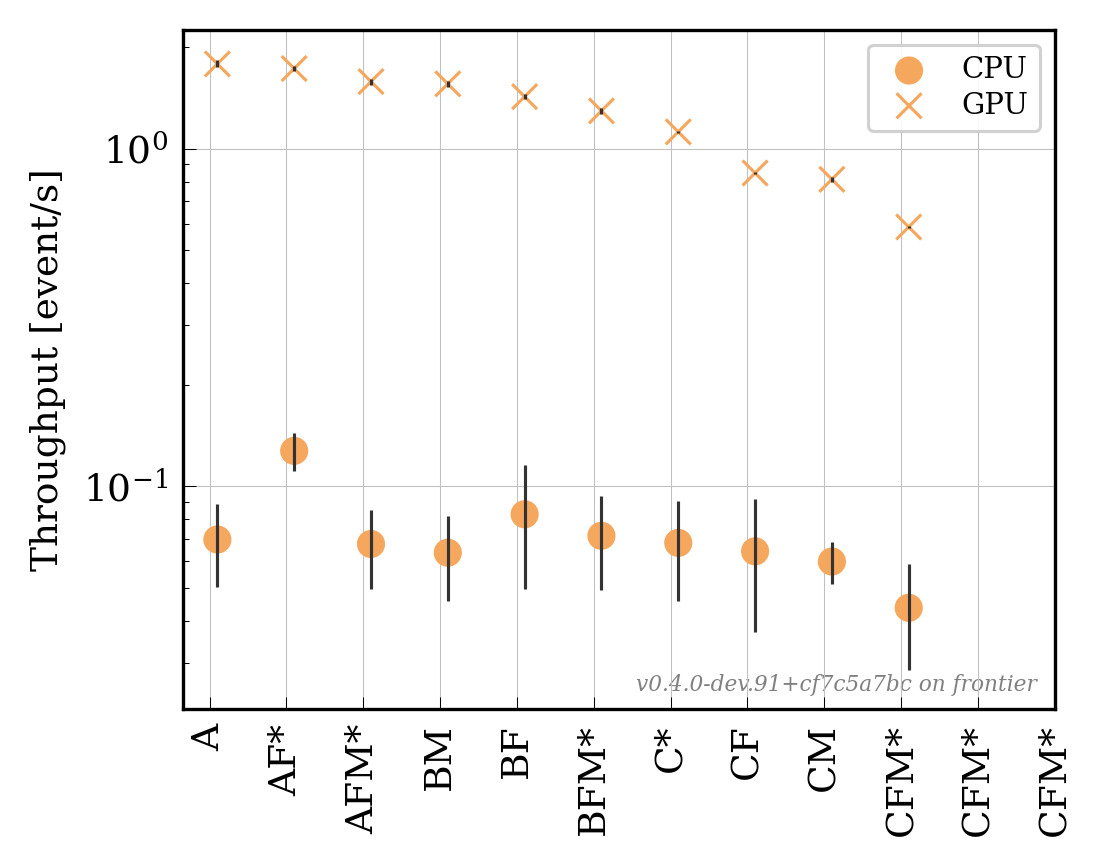

In [25]:
(fig, ax) = plt.subplots()
analyze.plot_event_rate(ax, frontier)
ax.legend()

# Occupancy

In [79]:
BYTES_PER_REG = 4 # 32-bit registers

def load_kernels(results, problem, geo):
    return results.load_results((problem, geo, 'gpu'), 0)['system']['kernels']

def kernel_stats_dataframe(kernel_stats):
    values = []
    index = []
    for (instance, kernels) in kernel_stats.items():
        arch, _, geo = instance.partition('/')
        for (ki, stats) in enumerate(kernels):
            stats.pop('stack_size', None) # Unavailable with HIP
            row = list(stats.values())
            row.append(ki)
            values.append(row)
            name = stats['name']
            if name == "extend-from-secondaries":
                # Fixup duplicate name
                name = f"{name}-{ki}"
            index.append((arch, geo, name))
    index=pd.MultiIndex.from_tuples(index, names=('arch', 'geo', 'name'))
    columns = pd.Index(list(stats.keys()) + ['kernel_index'])
    result = pd.DataFrame(values, index=index, columns=columns)
    del result['name']
    del result['print_buffer_size']
    result['register_mem'] = result['num_regs'] * BYTES_PER_REG
    return result

In [73]:
def plot_kernel_mem(ax, ksdf, colors, labels):
    labels = ['local_mem', 'register_mem']
    y = np.arange(len(labels))
    width = .9 / len(multimem)
    ynudge = np.linspace(-0.34, 0.34, len(multimem))
    
    for (i, (k, mem)) in enumerate(multimem.items()):
        values = np.array(list(mem.values()), dtype=dtype)

        ax.barh(y + ynudge[i], values['register'], width,
                color=colors[k], label=f'{pretty_labels[k]}')
        ax.barh(y + ynudge[i], values['local'], width, left=values['register'],
                color=colors[k + '.spill'])#, label=f'Local spill ({pretty_labels[k]})')

    ax.invert_yaxis();
    ax.set_xlabel('Memory [B]')
    ax.set_yticks(y, labels)
    leg = ax.legend()
    leg.set_title("Register usage (light)\nLocal spill (dark)")
    leg.get_title().set_fontsize('x-small')

In [31]:
kernel_stats = {
    'cuda/vecgeom': load_kernels(summit, 'testem3-flat+field+msc', 'vecgeom'),
    'cuda/orange': load_kernels(summit, 'testem3-flat+field+msc', 'orange'),
    'hip/orange': load_kernels(frontier, 'testem3-flat+field+msc', 'orange'),
}
pretty_labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
colors = {
    'cuda/vecgeom': (191, 40, 96),
    'cuda/vecgeom.spill': (107, 76, 88),
    'cuda/orange': (153, 168, 50),
    'cuda/orange.spill': (106, 112, 67),
    'hip/orange': (57, 140, 173),
    'hip/orange.spill': (78, 101, 110),
}
colors = {k: np.array(v, dtype=float) / 255 for k, v in colors.items()}

In [80]:
ksdf = kernel_stats_dataframe(kernel_stats)

In [81]:
mem = ksdf['local_mem']

In [82]:
with open("kernel-occupancy.md", "w") as f:
    analyze.dump_markdown(
        f,
        list(ksdf_mem.index.names) + ['local', 'register', 'occupancy'],
        np.concatenate([
            np.array([list(v) for v in ksdf_mem.index]).T,
            [
                ksdf['local_mem'].apply("{:d}".format),
                ksdf['register_mem'].apply("{:d}".format),
                ksdf['occupancy'].apply("{:.03f}".format)
            ],
        ], axis=0).T,
        alignment="<<<>>>"
    )

In [107]:
labels = {
    'cuda/vecgeom': 'NVIDIA V100 (VecGeom)',
    'cuda/orange': 'NVIDIA V100 (ORANGE)',
    'hip/orange': 'AMD MI250 (ORANGE)',
}
markers = {
    'cuda/vecgeom': '.',
    'cuda/orange': '+',
    'hip/orange': 'x',
}

(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['register_mem'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
ax.set_xlabel('Register usage [B]')
ax.set_ylabel('Memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/reg-vs-spill.png')
fig.savefig('plots/reg-vs-spill.pdf', transparent=True)
plt.close()

In [111]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    tot_mem = ks['register_mem'] + ks['local_mem']
    s = ax.scatter(ks['occupancy'], tot_mem,
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Register + spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
fig.savefig('plots/occupancy-vs-mem.png')
fig.savefig('plots/occupancy-vs-mem.pdf', transparent=True)
plt.close()

In [109]:
(fig, ax) = plt.subplots()
for key, ks in ksdf.unstack('name').iterrows():
    k = '/'.join(key)
    ks = ks.unstack(level=0)
    s = ax.scatter(ks['occupancy'], ks['local_mem'],
               c=ks['kernel_index'],
               marker=markers[k], label=labels[k])
#ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Local memory spill [B]')
ax.legend()
cb = fig.colorbar(s)

plt.tight_layout()
#fig.savefig('plots/occupancy-vs-spill.png')
fig.savefig('plots/occupancy-vs-spill.pdf', transparent=True)
plt.close()

In [110]:
ksdf[ksdf['local_mem'] > 64]

const_mem    heap_size  \
arch geo     name                                                       
cuda vecgeom scat-rayleigh                         20776      8388608   
     orange  initialize-tracks                         0      8388608   
             along-step-uniform-msc-propagate          0      8388608   
             photoel-livermore                         0      8388608   
             scat-rayleigh                             0      8388608   
             geo-boundary                              0      8388608   
hip  orange  initialize-tracks                         0  68702699520   
             geo-boundary                              0  68702699520   

                                               local_mem  max_blocks_per_cu  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                           104                  3   
     orange  initialize-tracks                       112                  4   
             along-step-uniform-msc-propagate        240                  2   
             photoel-livermore                        80                  3   
             scat-rayleigh                           104                  3   
             geo-boundary                            152                  3   
hip  orange  initialize-tracks                       120                  5   
             geo-boundary                            304                  5   

                                               max_threads_per_block  \
arch geo     name                                                      
cuda vecgeom scat-rayleigh                                       896   
     orange  initialize-tracks                                  1024   
             along-step-uniform-msc-propagate                    256   
             photoel-livermore                                   896   
             scat-rayleigh                                       896   
             geo-boundary                                        768   
hip  orange  initialize-tracks                                  1024   
             geo-boundary                                       1024   

                                               max_warps_per_eu  num_regs  \
arch geo     name                                                           
cuda vecgeom scat-rayleigh                                   24        66   
     orange  initialize-tracks                               32        64   
             along-step-uniform-msc-propagate                16       128   
             photoel-livermore                               24        68   
             scat-rayleigh                                   24        66   
             geo-boundary                                    24        80   
hip  orange  initialize-tracks                                5        90   
             geo-boundary                                     5        92   

                                               occupancy  threads_per_block  \
arch geo     name                                                             
cuda vecgeom scat-rayleigh                         0.375                256   
     orange  initialize-tracks                     0.500                256   
             along-step-uniform-msc-propagate      0.250                256   
             photoel-livermore                     0.375                256   
             scat-rayleigh                         0.375                256   
             geo-boundary                          0.375                256   
hip  orange  initialize-tracks                     0.625                256   
             geo-boundary                          0.625                256   

                                               kernel_index  register_mem  
arch geo     name                                                          
cuda vecgeom scat-rayleigh                               17           264  
     orange  i